# Applying the Model

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
img_md_subset = pd.read_csv('../../../Data/ifcb_ecotaxa_subset_merged.csv')
img_md_subset = img_md_subset.drop('Unnamed: 0', 1)

In [3]:
# For now only using validated images
img_md_subset = img_md_subset[img_md_subset.object_annotation_status == 'validated']

In [4]:
img_md_subset.head()

,object_id,object_annotation_status,object_annotation_category,object_annotation_hierarchy,sample_flag,object_lat,object_lon,object_date,object_time,merged_category,geometry
0,D20180221T193119_IFCB116_01153,validated,Pyramimonas,living>Eukaryota>Archaeplastida>Viridiplantae>...,good,-64.7535,-64.1339,20180221,193119,chlorophytes,POINT (-64.1339 -64.7535)
1,D20180221T202431_IFCB116_00153,validated,Gymnodinium,living>Eukaryota>Harosa>Alveolata>Myzozoa>Holo...,good,-64.7741,-64.1655,20180221,202431,gymnodinium,POINT (-64.16549999999999 -64.7741)
2,D20180221T202431_IFCB116_01303,validated,Gymnodinium,living>Eukaryota>Harosa>Alveolata>Myzozoa>Holo...,good,-64.7741,-64.1655,20180221,202431,gymnodinium,POINT (-64.16549999999999 -64.7741)
3,D20180221T202431_IFCB116_03008,validated,Katodinium,living>Eukaryota>Harosa>Alveolata>Myzozoa>Holo...,good,-64.7741,-64.1655,20180221,202431,katodinium,POINT (-64.16549999999999 -64.7741)
4,D20180221T212254_IFCB116_07034,validated,Pyramimonas,living>Eukaryota>Archaeplastida>Viridiplantae>...,good,-64.7802,-63.9785,20180221,212254,chlorophytes,POINT (-63.9785 -64.78019999999999)


In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
import glob, os

file_dir = '../../../Data/140920_export/'

os.chdir(file_dir)
fn_list = []
for file in glob.glob("*.png"):
    fn_list.append(file)
    
print(len(fn_list))

fn_edit = [x[:-4] for x in fn_list]

available_subset = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(available_subset)

1976952


35993

In [25]:
class_id_dict = {'Amphiprora': 0,
 'Bacillariophyceae': 1,
 'Banquisia belgicae': 2,
 'Ceratium': 3,
 'Chaetoceros single': 4,
 'Chaetoceros<Mediophyceae': 5,
 'Ciliophora': 6,
 'Corethron': 7,
 'Cryptophyta': 8,
 'Cylindrotheca': 9,
 'Dactyliosolen': 10,
 'Dictyochales': 11,
 'Dinophyceae': 12,
 'Dinophysis': 13,
 'Eucampia': 14,
 'Eucampia chain': 15,
 'Guinardia': 16,
 'Gymnodinium': 17,
 'Gyrodinium': 18,
 'Katodinium': 19,
 'Licmophora': 20,
 'Membraneis': 21,
 'Navicula': 22,
 'Nitzschia frigida': 23,
 'Odontella sp.': 24,
 'Phaeocystis': 25,
 'Proboscia sp.': 26,
 'Pseudo-Nitzschia chain': 27,
 'Pyramimonas': 28,
 'Rhizosolenia': 29,
 'Thalassiosira': 30,
 'Tintinnida': 31,
 'Torodinium': 32,
 'Warnowia': 33,
 'badfocus<artefact': 34,
 'bead': 35,
 'bubble': 36,
 'centric': 37,
 'centric 1 temp': 38,
 'centric 2 temp': 39,
 'centric 3 temp': 40,
 'centric 4 temp': 41,
 'centric 6 temp': 42,
 'chain<centric': 43,
 'chain<pennate': 44,
 'detritus': 45,
 'dinoflagellate-i': 46,
 'dinoflagellate-ii': 47,
 'dinoflagellate-iii': 48,
 'multiple<other': 49,
 'part<other': 50,
 'pennate 10 temp': 51,
 'pennate 11 temp': 52,
 'pennate 2 temp': 53,
 'pennate 7 temp': 54,
 'pennate<Bacillariophyta': 55,
 't002': 56,
 't003': 57,
 't005': 58,
 't006': 59,
 't007': 60,
 't008': 61,
 't009': 62,
 't010': 63,
 't011': 64,
 't012': 65,
 't013': 66,
 't016': 67,
 't017': 68,
 't019': 69,
 'temp cylindrotheca': 70}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

In [8]:
len(class_id_dict)

71

In [9]:
frac = 0.05
int(len(available_subset) * frac)
frac = 1

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

images = []
labels = []
merged_labels = []
original_labels = []

for index, row in available_subset.sample(frac=frac).iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images.append(image.img_to_array(img))
    #labels.append(class_id_dict[row['object_annotation_category']])
    merged_labels.append(row['merged_category'])
    original_labels.append(row['object_annotation_category'])
    
images = np.array(images)
labels = np.array(labels)
merged_labels = np.array(merged_labels)
original_labels = np.array(original_labels)

In [11]:
X_predict = images / 130
np.mean(X_predict), np.std(X_predict)

(1.0059602, 0.3034187)

In [12]:
from tensorflow import keras

model = keras.models.load_model('../model_weights_all_classes.hdf5')

In [15]:
X_predict.shape

(27218, 150, 150, 1)

In [ ]:
def generate_data(directory, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    while True:
        
        images = []
        labels = []
        merged_labels = []
        original_labels = []

        for index, row in available_subset.sample(frac=frac).iterrows():

            # TODO need to think about optimal size and that size actually corresponds to class
            # maybe add blackspace instead of interpolating because it is changing the morphology

            img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
            images.append(image.img_to_array(img))
            labels.append(class_id_dict[row['merged_category']])
            merged_labels.append(row['merged_category'])
            original_labels.append(row['object_annotation_category'])
        
        
        
        image_batch = []
        for b in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            image = cv2.resize(cv2.imread(sample[0]), INPUT_SHAPE)
            image_batch.append((image.astype(float) - 128) / 128)

        yield np.array(image_batch)

In [19]:
predictions = np.argmax(model.predict(X_predict), axis=1)

In [ ]:
model.predict_generator(generator = tile_gen.tile_generator(clean_px, batch_size=100, flatten=True, canopy=True), steps=len(clean_px) // 100, verbose=1)

In [20]:
classes, counts = np.unique(predictions, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]),
 array([ 502,  440,   70,  250,  179,  691,  686,  340, 1019,  474,  170,
         695,   92,   53,   98,   62,  388,  468,   84,  532,  112,  309,
         402,  847,   55,  873,  428,  985,  798,  110,  499,   75,  221,
          59, 2042,  536,  170,  606, 1765,  906, 1599,  117, 1656,   32,
         814, 1102,  224,  642,  155,  771,  201,  590, 1026,  623,  746,
         230, 1038,  653,  212,  118, 1047,  197,   96,  185,  652,  479,
         299,   75,   39,  762,  522]))

In [28]:
class_id_dict['Amphiprora']

0

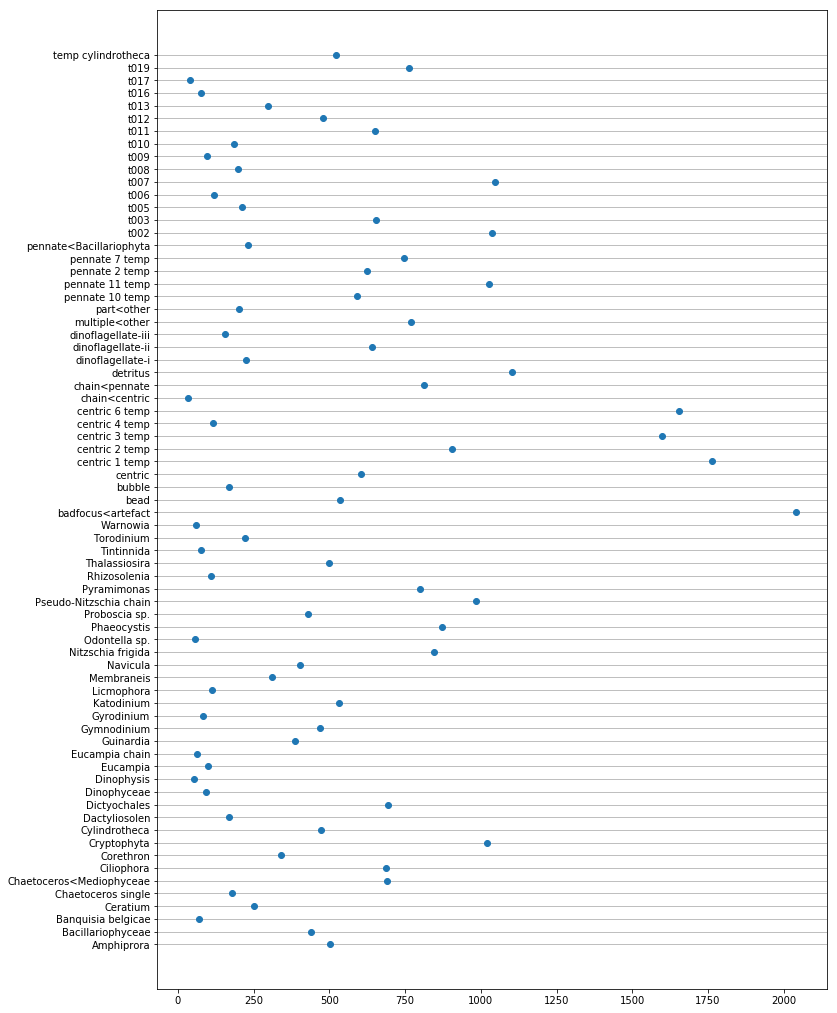

In [32]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(counts, classes)
ax.set_yticks(range(0,len(class_id_dict)))
ax.set_yticklabels([id_class_dict[x] for x in classes])
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('output_predictions.png', dpi=300)
plt.show()

In [16]:
min_count = 25
unique_validated = available_subset.groupby('object_annotation_category')['object_id'].nunique()

sufficient_classes = unique_validated[unique_validated >= min_count]

In [17]:
len(sufficient_classes)

72

In [29]:
#classes, counts = np.unique(labels, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]),
 array([ 414,  390,   55,   21,  107,  587,  331,   77,  882,  326,  138,
          99,   66,   16,   20,   15,   18,  311,   61,  481,   65,  130,
         322,  814,   35,   10,  328,  658,  279,   26,  305,   26,   87,
          31, 2024,  374,  126,  446, 1688,  813, 1563,  100, 1645,   13,
         641, 1040,  203,  466,  146,  573,  151,  403,  934,  490,  513,
         184,  613,  273,  211,  105,  936,  114,   94,  149,  635,  461,
         280,    6,   31,  750,  493]))

In [33]:
sufficient_classes

object_annotation_category
Amphiprora                   502
Bacillariophyceae            429
Banquisia belgicae            43
Ceratium                     214
Chaetoceros single           159
Chaetoceros<Mediophyceae     729
Ciliophora                   546
Corethron                    309
Cryptophyta                 1045
Cylindrotheca                377
Dactyliosolen                148
Dictyochales                 737
Dinophyceae                  145
Dinophysis                    29
Eucampia                     102
Eucampia chain                62
Guinardia                    360
Gymnodinium                  464
Gyrodinium                    85
Katodinium                   477
Licmophora                    78
Membraneis                   260
Navicula                     350
Nitzschia frigida            833
Odontella sp.                 37
Phaeocystis                 1091
Proboscia sp.                345
Pseudo-Nitzschia chain       995
Pyramimonas                 1408
Rhizosolenia    

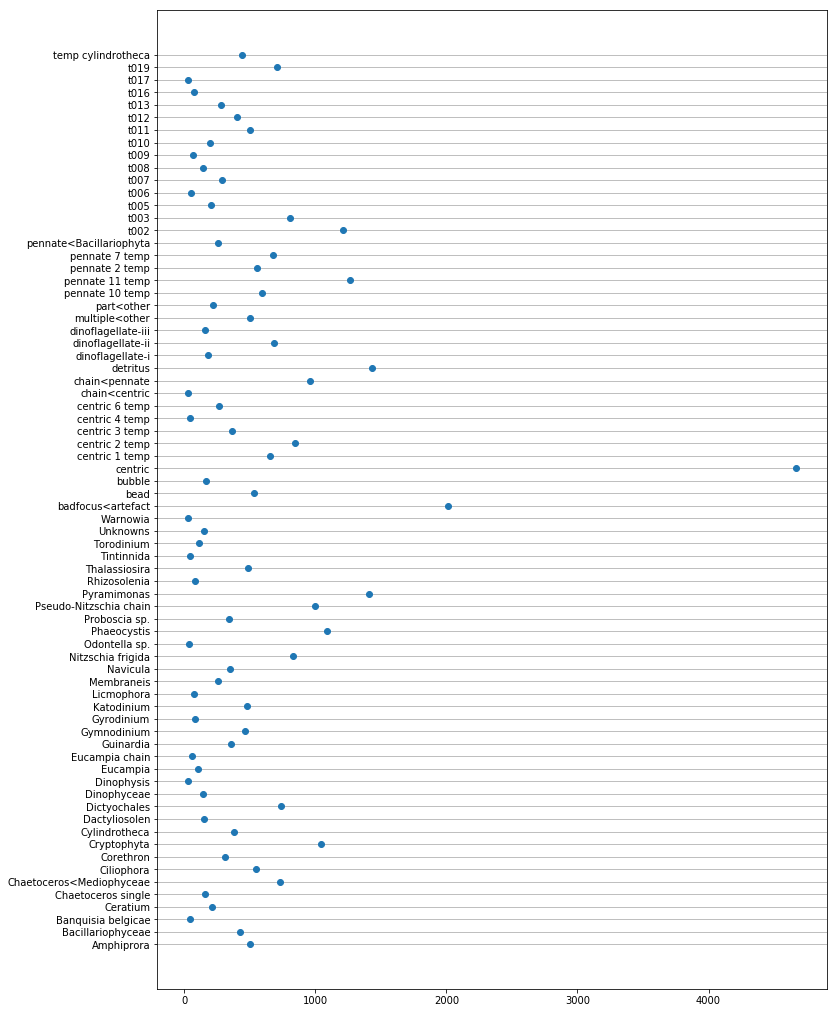

In [18]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(sufficient_classes.values, range(0,len(sufficient_classes)))
ax.set_yticks(range(0,len(sufficient_classes)))
ax.set_yticklabels(list(sufficient_classes.index))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

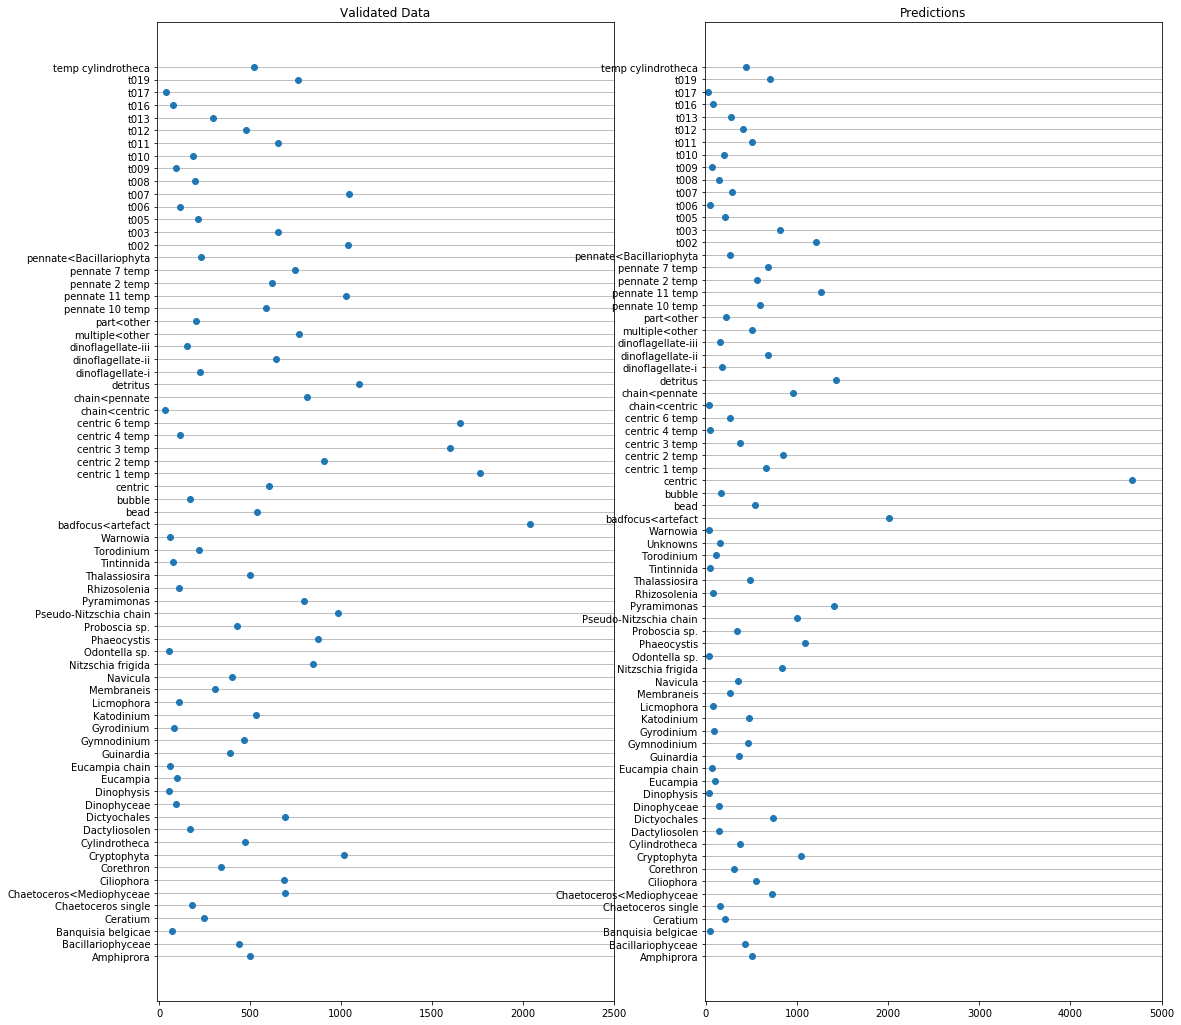

In [39]:
fig, ax = plt.subplots(1,2, figsize=(18, 18))
ax[1].scatter(sufficient_classes.values, range(0,len(sufficient_classes)))
ax[1].set_yticks(range(0,len(sufficient_classes)))
ax[1].set_yticklabels(list(sufficient_classes.index))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax[1].set_axisbelow(True)
ax[1].set_xlim(-10,5000)
ax[1].set_title("Predictions")


# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax[1].grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax[0].scatter(counts, classes)
ax[0].set_yticks(range(0,len(class_id_dict)))
ax[0].set_yticklabels([id_class_dict[x] for x in classes])
ax[0].set_xlim(-10,2500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax[0].set_axisbelow(True)
ax[0].set_title("Validated Data")

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax[0].grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig('output_predictions_comparison_full.png', dpi=300)
plt.show()

In [ ]:
# pull out only validated images and run it on them and see how close the total numbers compare